In [2]:
import scipy.stats as sps 
from scipy.stats import gamma
import numpy as np
import yfinance as yf
import pandas as pd
from IPython.display import display, Markdown, Latex
from numpy import random as npr
import warnings
from itertools import combinations,batched,accumulate

import matplotlib.pyplot as plt
import matplotlib.markers
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm


In [3]:
# Import the yfinance. If you get module not found error the run !pip install yfianance from your Jupyter notebook
#https://habr.com/ru/articles/487644/
data = {}
# Get the data for the stock AAPL
tickers_list = ['CIB', 'BAK', 'TSVT', 'AYI', 'TSLA']


for ticker in tickers_list:
    data[ticker] = yf.download(ticker,'2022-01-01','2024-01-09')['Adj Close']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



-----------------------

# Оценки доходностей



In [4]:
RED = (0.2, 0, 0, 0.2)
GREEN = (0, 0.2, 0, 0.2)
BLUE = (0, 0, 0.2, 0.2)
NOCOL = (0, 0, 0, 0)

FIGSIZE = (16, 4)
MARGINS = {
    "left": 0.1,
    "bottom": 0.15,
    "right": 0.999,
    "top": 0.999
}
CMAP = 'gist_ncar'


def make_fig( projection=None, nrows=1, ncols=1, index=1):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(**MARGINS)
    fig.patch.set_facecolor(NOCOL)
    ax = fig.add_subplot( nrows,ncols,index,projection = projection,)
    return fig,ax

In [5]:
def make_kernel(data, kernel):
    size = len(data)
    h = hopt = pow(2.4*np.exp(4)/size, 0.2)
    
    g = lambda x_: sum([kernel((x_-x)/(h)) for x in data])/size/h
    x = data.to_numpy()
    id = np.argsort(x)

    y = np.array([g(x_) for x_ in x])
        
        
    return x[id],y[id]

In [6]:
ker_list = [
    lambda x:(1 - np.abs(x)) * (abs(x) <= 1),
    lambda x:0.75*(1-x*x) * (abs(x) <= 1),
    lambda x: 15/16*pow(1-x*x, 2) * (abs(x) <= 1),
    lambda x: 35/32*pow(1-x*x,3)* (abs(x) <= 1),
    lambda x: 70/81*pow(1-abs(pow(x,3)),3)* (abs(x) <= 1),
    lambda x: pow(2*np.pi,-0.5)*np.exp(-0.5*x*x),
    lambda x: 0.25*np.pi*np.cos(0.5*np.pi*x)*(abs(x) <= 1),
    lambda x: pow(np.exp(x)+2+np.exp(-x),-1),
    lambda x: 2/np.pi*pow(np.exp(x)+np.exp(-x),-1)
]

bins_list = lambda size:[
    int(1 + np.log2(size)),
    4*int(pow(0.75*pow(size - 1, 2), 0.2)),
    int(5*np.log10(size))
]

def draw_hist(data,ax):
    #draw hist
    for bins in bins_list(len(data)):
        h, bins, pathces = ax.hist(data, bins=bins, color=BLUE, density=True)
        ax.hist(data, bins=bins, color=BLUE, density=True)
        #ax.plot(bins[:-1],h)
    # draw kernel hist
    for i,kernel in enumerate(ker_list):
        x, y = make_kernel(data, kernel)
        ax.plot(x, y, label = f"{i}")

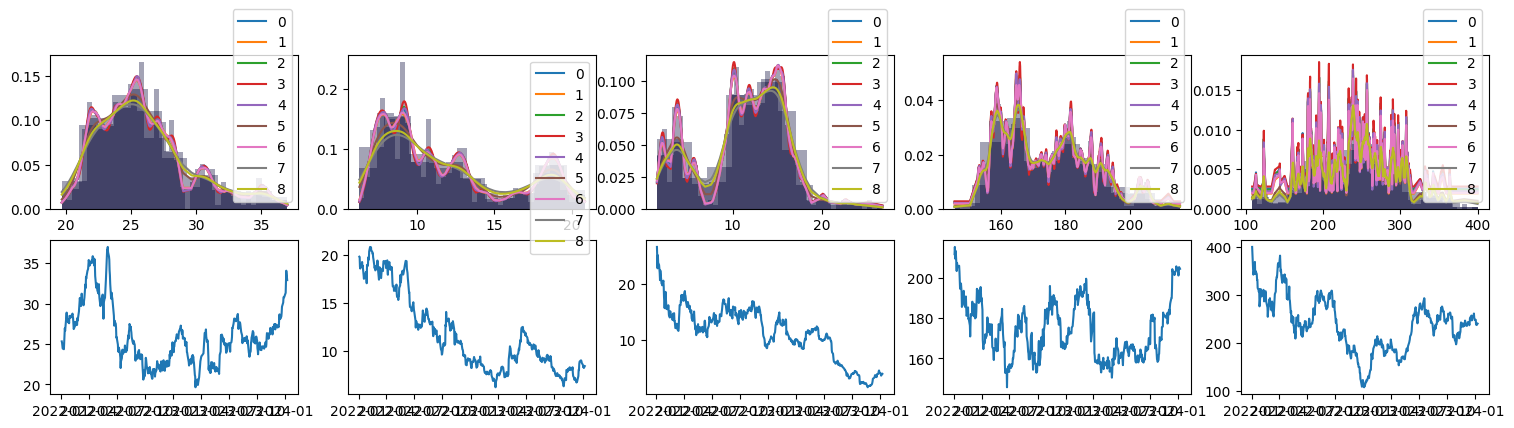

In [7]:
tickers_len = len(tickers_list)
fig, ax = make_fig(nrows=2, ncols=tickers_len, index=tickers_len+1)

for i,ticker in enumerate(tickers_list):
    if i<tickers_len:
        cax = fig.add_subplot(2,tickers_len,i+1)
    draw_hist(data[ticker],cax)
    cax.legend()
    
    ax.plot(data[ticker])
    if i<tickers_len-1:
        ax = fig.add_subplot(2,tickers_len,i+tickers_len+2)
    

In [8]:
@np.vectorize
def W(x,y):
  return max(x+y-1,0)

@np.vectorize
def M(x,y):
  return min(x,y)

@np.vectorize
def P(x,y):
  return x*y

def make_copula_Ferche(alpha = 0.7, beta = 0.2):
    @np.vectorize
    def copula_Ferche(u,v):
        return alpha*M(u,v)+(1-alpha-beta)*P(u,v) + beta*W(u,v)
    return copula_Ferche

In [9]:
x, y = make_kernel(data["CIB"], lambda x: 2/np.pi*pow(np.exp(x)+np.exp(-x),-1) )
x1 = np.linspace(x[0],x[-1],len(x))
y1 = np.fromiter(accumulate(y[:-1]*(x[1:] - x[:-1])), dtype = float)
y1[0] = 0
y1 = np.append(y1,[1,])

x, y = make_kernel(data["AYI"], lambda x: 2/np.pi*pow(np.exp(x)+np.exp(-x),-1) )
x2 = np.linspace(x.min(),x.max(),len(x))
y2 = np.fromiter(accumulate(y[:-1]*(x[1:] - x[:-1])), dtype = float)
y2[0] = 0
y2 = np.append(y2,[1,])


C = make_copula_Ferche()
u,v = np.meshgrid(y1,y2)
z = C(u,v)

x,y = np.meshgrid(x1,x2)

In [10]:
z.shape,x.shape,y.shape

((506, 506), (506, 506), (506, 506))

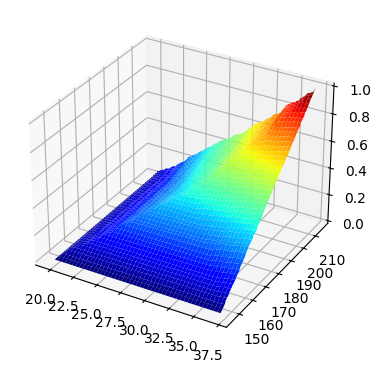

In [11]:
fig,ax = make_fig(projection="3d")
ax.plot_surface(x,y,z, cmap = cm.jet)


In [19]:
# считаем меру риска CVar для уровня значимости alpha = 99.5% 
alpha = 0.995
id = z< 1- alpha

z[id],x[id],y[id]


(array([0.        , 0.        , 0.        , ..., 0.00483628, 0.        ,
        0.00491366]),
 array([19.65865326, 19.69296497, 19.72727667, ..., 19.69296497,
        19.65865326, 19.69296497]),
 array([145.69084167, 145.69084167, 145.69084167, ..., 215.27383426,
        215.41189575, 215.41189575]))

In [20]:
# для различных портфелей построим значения меры риска
d1 = npr.uniform(0,1,1000)

#мера риска
Var =np.array([x[id]*d+y[id]*(1-d) for d in d1] )


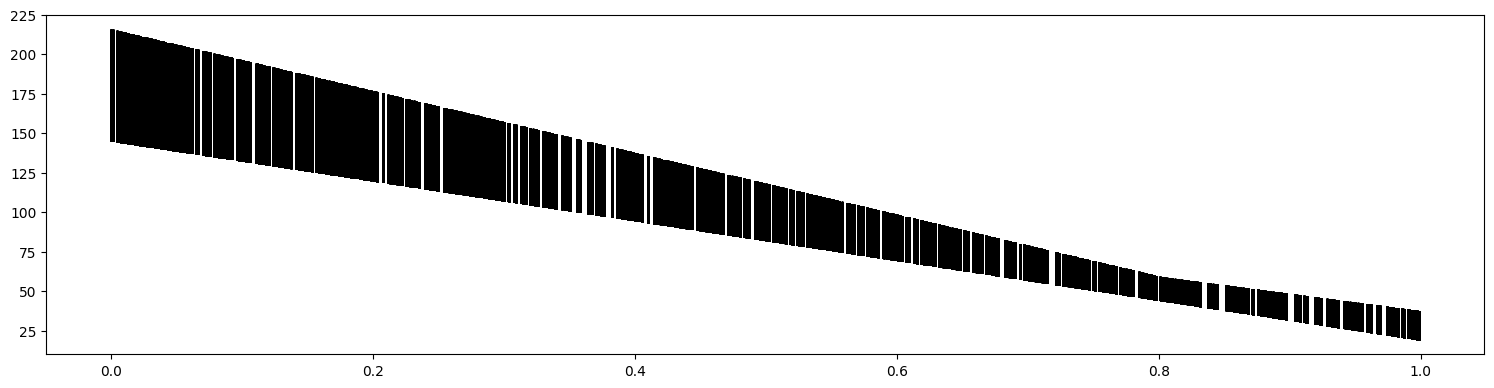

In [21]:
fig,ax = make_fig()
for d in d1:
    Var = np.array(x[id]*d+y[id]*(1-d))
    ax.scatter(np.full_like(Var,d),Var, s= 1, color = (0,0,0))

In [572]:

# def Estep(X,p,psi):
#     N = X.size
#     K = p.size

#     G =np.zeros((K,N))
#     for j in range(N):
#         psij = psi(X[j])
#         dotppsi = np.dot(p,psij)
#         G[:,j] = p*psij/(dotppsi)
#     return G

# def Mstep(G,X):
#     K,N = G.shape
#     n = np.array([sum(G[i,:]) for i in range(K)])
#     p = n/N
#     a = np.array([np.dot(G[i,:],X) for i in range(K)])/n
#     sigma = np.array([np.dot(G[i,:],(X-a[i])*(X-a[i])) for i in range(K)])/n
#     return p,a,sigma

# a1 = 24
# a2 = 28
# sigma1 = 1
# sigma2 = 1
# psi = lambda x: np.array([ sps.norm.pdf(x,a1,sigma1), sps.norm.pdf(x,a2,sigma2)])

# p = np.array([0.5,0.5])
# T = 100
# for m in range(T):
#     G = Estep(data,p,psi)
#     p,a,sigma = Mstep(G,data)

# print(p)
# print(a)
# print(np.sqrt(sigma))

# sigma = np.sqrt(sigma)

In [573]:
columns = data.keys()
rows = [
    r"$\mathbb E$",
    r"$\mathbb D$",
]
df = pd.DataFrame(columns = columns, index=rows)
df.iloc[0] = list(map(np.mean,data.values()))
df.iloc[1] = list(map(np.std,data.values()))
display(Markdown(df.to_markdown()))

|             |      CIB |      BAK |     TSVT |      AYI |     TSLA |
|:------------|---------:|---------:|---------:|---------:|---------:|
| $\mathbb E$ | 26.0163  | 11.7755  | 11.3173  | 174.331  | 240.332  |
| $\mathbb D$ |  3.60947 |  4.04054 |  4.84445 |  13.9429 |  55.0574 |

In [574]:

def ellipse(a=1, b=1, size=1):
    X = np.zeros(shape=(size, 2))
    theta = np.linspace(0, 2*np.pi, size)
    X[:, 0] = a*np.cos(theta)
    X[:, 1] = b*np.sin(theta)
    return X


def hyperbola(a=1, b=1, size=1):
    X = np.zeros(shape=(size, 2))
    Y = np.zeros(shape=(size, 2))
    theta = np.linspace(-2, 2, size)
    X[:, 0] = a*np.cosh(theta)
    X[:, 1] = b*np.sinh(theta)

    Y[:, 0] = -a*np.cosh(theta)
    Y[:, 1] = b*np.sinh(theta)

    return np.vstack((X, Y))


def intersect_lines(a=1, b=1, size=1):
    X = np.zeros(shape=(size, 2))
    Y = np.zeros(shape=(size, 2))
    theta = np.linspace(-1, 1, size)
    X[:, 0] = np.linspace(-1, 1, size)
    X[:, 1] = -a/b * X[:, 0]

    Y[:, 0] = np.linspace(-1, 1, size)
    Y[:, 1] = a/b * X[:, 0]

    return np.vstack((X, Y))


def trans_canonic_curve(A, B, C, D, E, F, size=100):
    """ 
    уравнение вида Ax^2+2Bxy+Cy^2+2Dx+2Ey+F=0
    """

    # определяем сдвиг (в случае det!=0)
    x0 = np.linalg.solve(
        a=np.array(np.array([[A, B], [B, C]])),
        b=np.array([-D, -E]).reshape((-1, 1))
    )
    D_ = (A*x0[0]*x0[0] + C*x0[1]*x0[1]) + (2*D*x0[0] + 2*E*x0[1]) + F
    # новое уравнение Au^2+2Buv+Cv^2+D_=0
    x0 = x0.T

    if B:
        # случаи B!=0 не рассматриваем (но вообще по ккоду выше написаны матрицы поворота)
        return None

    # нормируем уравнение Au^2+Cv^2+D_=0

    if not (A*C):
        return None  # случаи A*C==0 не рассматриваем

    if A*C > 0:
        if A*D_ < 0:
            # эллипс
            a, b = np.sqrt(-D_/A), np.sqrt(-D_/C)
            return ellipse(a, b, size) + x0
        elif A*D_ > 0:
            return np.array([0, 0]).reshape(-1, 1)  # точка
        elif not (D_):
            print("пара пересекающихся мнимых прямых")
            return np.array([])
    elif A*C < 0:
        if A*D_ < 0:
            # гипербола
            a, b = np.sqrt(-D_/A), np.sqrt(D_/C)
            return hyperbola(a, b, size) + x0
        elif A*D_ > 0:
            # гипербола
            a, b = np.sqrt(D_/A), np.sqrt(-D_/C)
            return hyperbola(a, b, size) + x0
        else:
            # |A|u^2-|C|v^2=0
            a, b = np.sqrt(np.abs(A)), np.sqrt(np.abs(C))
            return intersect_lines(a, b, size) + x0


def get_det(A, B, C):
    return np.linalg.det(np.array([[A, B], [B, C]]))


def get_det1(A, B, C, D, E, F):
    return np.linalg.det(np.array([[A, B, D], [B, C, E], [D, E, F]]))


def dkm_boundaty(E, D):
    """  
    x.shape==(-1, 3)
    batch_size = 10
    для меры риска будем использоавть взвешеннуб смесь матожидания и дисперсии pi = D - beta*E
    """
    BETA = 0.9
    BATCH_SIZE = 20
    sol = []

    id_batches = batched(E.argsort(), BATCH_SIZE)
    for batch in id_batches:
        b = np.array(batch)
        Q = np.stack((D[b], E[b]), axis=1)
        sol.append(min(Q, key=lambda q: q[0] - BETA*q[1]))

    return np.array(sol).T


def dkm_boundaty_smooth(x, m, cov, EPSILON = 0.1):
    """  
    x.shape==(-1, 3)
    batch_size = 10
    для меры риска будем использоавть взвешеннуб смесь матожидания и дисперсии pi = D - beta*E
    """
    BETA = 0.9
    sol = []
    sol_im= []
    count = 1
    for i in np.arange(0.0, 1, EPSILON):
        
        id = (x[:, 0] > i) & (x[:, 0] < i + EPSILON)
        order = np.arange(0, 1, EPSILON) if count%2  else np.arange(1-EPSILON, 0+EPSILON, -EPSILON)
        count+=1
        countj = 1
        for j in  order:
            jd = (x[id][:,1] > j) & (x[id][:,1] < j + EPSILON)
            
            if x.shape[1]==2:
                batch = x[id][jd]
                E = batch@m
                D = np.sqrt([x_@cov@x_.T for x_ in batch])
                Q = np.stack((D, E), axis=1)
                if len(Q): 
                    s = min(Q, key=lambda q: q[0] - BETA*q[1])
                    sol.append(s)
                    sol_im.append(batch[Q == s])
            else:
                orderj = np.arange(0, 1, EPSILON) if count%2  else np.arange(1-EPSILON, 0+EPSILON, -EPSILON)
                countj += 1
                for k in  orderj:
                    kd = (x[id][jd][:,2] > k) &( x[id][jd][:,2] < k + EPSILON)
                    batch = x[id][jd][kd]

                    E = batch@m
                    D = np.sqrt([x_@cov@x_.T for x_ in batch])
                    Q = np.stack((D, E), axis=1)
                    norm = 0 if not(sol) else np.linalg.norm(Q-sol[-1]) 
                    if len(Q):
                        s = min(Q, key=lambda q: q[0] - BETA*q[1])
                        sol.append(s)
                        sol_im.append(batch[(Q == s)[:,0]])
    #D,E  = np.array(sol).T
    return np.array(sol).T, np.array(sol_im)


def dkm(m: np.array, cov: np.array, fig, ax):
    sigma = np.sqrt(cov.diagonal())
    r12 = cov[0, 1]/np.prod(sigma)

    if -1 < r12 and r12 < 1:
        print("рисуем гиперболу по коэффициентам")
    elif r12 == 1:
        if sigma[0] == sigma[1]:
            print("прямая")
        else:
            print("две прямых (пересекающихся)")
    elif r12 == -1:
        print("две прямых (пересекающихся)")

    A = -pow(m[0]-m[1], 2)
    B = 0
    C = pow(sigma[0]-sigma[1], 2) + 2*(1-r12)*sigma[0]*sigma[1]
    D = 0
    E = (m[0]+m[1])*r12*sigma[0]*sigma[1]-m[1] * \
        pow(sigma[0], 2) - m[0]*pow(sigma[1], 2)
    F = pow(m[1]*sigma[0], 2) + pow(m[0]*sigma[1], 2) - \
        2*m[0]*m[1]*r12*sigma[0]*sigma[1]

    det = get_det(A, B, C)
    det1 = get_det1(A, B, C, D, E, F)
    if not (det):
        return

    # РИСУНОК
    x = trans_canonic_curve(A, B, C, D, E, F, size=10000)
    if not (x.size):
        return
    x = x[x[:, 1] < max(m)]
    x = x[x[:, 1] > min(m)]
    x = x[x[:, 0] < max(sigma)**2]
    x = x[x[:, 0] > 0]

    ax.plot(x[:, 0], x[:, 1])

In [583]:
border = 3
ticker_cut_list = tickers_list[:border]
COV = pd.DataFrame(np.cov([data[ticker].to_numpy() for ticker in  ticker_cut_list]), columns = ticker_cut_list, index = ticker_cut_list)
display(Markdown(COV.to_markdown()))
m = df.iloc[0][ticker_cut_list].to_numpy()
cov = COV.values

|      |       CIB |      BAK |      TSVT |
|:-----|----------:|---------:|----------:|
| CIB  | 13.0541   |  8.72917 |  0.842904 |
| BAK  |  8.72917  | 16.3583  | 13.365    |
| TSVT |  0.842904 | 13.365   | 23.5152   |

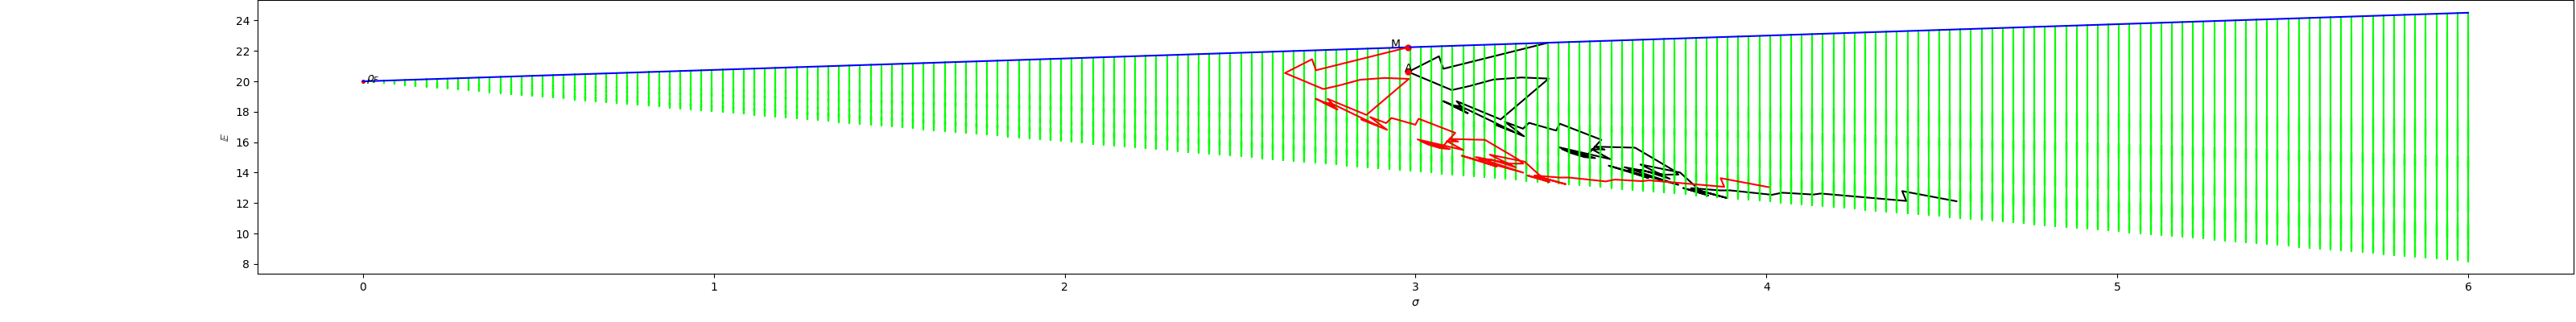

In [585]:
%matplotlib widget
SIZE = 1000
X = np.zeros(shape=(SIZE, 3))
X[:, 0] = npr.uniform(0, 1, SIZE)
X[:, 1] = npr.uniform(0, 1, SIZE)
X[:, 2] = 1 - X[:, 0] - X[:, 1]
X = X[X[:, 2] > 0]  # если выбираем модель марковица


(D,E),x = dkm_boundaty_smooth(X,m,cov,0.1)
fig, ax = make_fig()
ax.plot(D, E, color=(0, 0, 0))

#безрисковый актив
rhoF = 20


ax.set_ylabel(r"$\mathbb{E}$")
ax.set_xlabel(r"$\sigma$")

E1 = lambda sigma: rhoF + (E - rhoF)/D * sigma

for sigma in np.linspace(0,6,200):
    D1 = np.ones_like(D)*sigma
    ax.plot(D1,E1(sigma),color = (0,1,0))


idA,idM1 = D.argsort()[0],D.argsort()[-1]

EA,DA = E[idA],D[idA]
EM,DM = max(E1(DA)),D[idA]


ax.plot(DA,EA,"o",color = (1,0,0), markersize = 5)
ax.text(DA-0.01,EA, "A")
ax.text(0+0.01,rhoF, r"$\rho_F$")
ax.plot(np.zeros_like(D),E1(0),"o",color = (1,0,0),markersize=2)
ax.plot(DM,EM,"o",color = (1,0,0), markersize = 5)
ax.text(DM-0.05,EM, "M")

E2 = lambda sigma: rhoF + (EM - rhoF)/DM*sigma
sigma1 = np.linspace(0,6,100)
ax.plot(sigma1,E2(sigma1),color = (0,0,1), label = r"CAPITAL MARKET LINE")


sigma01 = (EM-rhoF)/(E1(D)[-1]-rhoF)

ax.plot(D*sigma01,E1(D*sigma01),color = (1,0,0))


In [586]:
x1 = x[-1]
x1 = x1*sigma01
x1, x1.sum(), sigma01

(array([[0.66712867, 0.19837476, 0.01654684]]),
 0.88205027456614,
 0.88205027456614)

In [588]:


D = np.sqrt([x@cov@x.T for x in x1])
E = x1@m + (1-sigma01)*rhoF
print(E,D)

#проверяем совпал ли портфель с выбранной точкой M
print(EM,DM)

[22.23843861104983] [2.97940478]
22.23843861104983 2.979404779705433


In [589]:
display(Markdown(f"портфель для {ticker_cut_list} : x = {x1}, доля безрискового актива = {1-sigma01:.2f}"))

портфель для ['CIB', 'BAK', 'TSVT'] : x = [[0.66712867 0.19837476 0.01654684]], доля безрискового актива = 0.12

In [580]:
def check_degenerate(m: np.ndarray):
    """ 
    проверка вырожденного случая
    m_1 = m_2 = ... m_n = = m*
    """
    return (m == m[0]).all()


def draw_risk_revenue_rel(cov_1, m_1, m_, I, A, B, C):
    k1 = (A*m_ - C*I)/(C*C-B*A)
    k2 = (B*I - m_*C)/(C*C-B*A)
    a = float(k1.T@cov_1@k1)
    b = float(k2.T@cov_1@k1)
    c = float(k2.T@cov_1@k2)

    parabola = np.vectorize(lambda x: a*pow(x, 2) + 2 * b * x + c)
    x = np.linspace(0, 20, 100)
    y = parabola(x)
    fig, ax = make_fig()
    ax.set_xlabel(r"$\mathbb{E}$")
    ax.set_ylabel(r"$\sigma$")
    ax.plot(x, y, label="эффективная граница", color=(0, 0, 1))
    ax.vlines(-b/a, y.min(), y.max(),
              label="минимальный риск", color=(1, 0, 0))
    ax.legend()


def not_deg_sol(cov_1, m_1, m_, I, A, B, C):
    return -cov_1@(m_1*(A*m_ - C*I) + B*I - m_*C)/(C*C-B*A)


def deg_sol(cov_1, I, A):
    return cov_1@I/A


def disable_warnings(func):
    def inner(*args, **kwargs):
        warnings.simplefilter("ignore")
        res = func(*args, **kwargs)
        warnings.simplefilter("default")
        return res
    return inner


@disable_warnings
def solution(m: np.ndarray, cov: np.array, draw: bool = False):
    m_ = m.reshape(-1, 1)
    I = np.ones(shape=m_.shape)

    m_1 = float(I.T@m_)
    cov_1 = np.linalg.inv(cov)

    A = float(I.T@cov_1@I)
    B = float(m_.T@cov_1@m_)
    C = float(I.T@cov_1@m_)

    sol = deg_sol(cov_1, I, A) if check_degenerate(m) else not_deg_sol(cov_1, m_1, m_, I, A, B, C)

    if draw: draw_risk_revenue_rel(cov_1, m_1, m_, I, A, B, C)

    return sol

|      |        CIB |       BAK |      TSVT |      AYI |      TSLA |
|:-----|-----------:|----------:|----------:|---------:|----------:|
| CIB  |  13.0541   |   8.72917 |  0.842904 |  10.6534 |  102.033  |
| BAK  |   8.72917  |  16.3583  | 13.365    |  12.1121 |  145.18   |
| TSVT |   0.842904 |  13.365   | 23.5152   |  16.9677 |   95.9078 |
| AYI  |  10.6534   |  12.1121  | 16.9677   | 194.789  |  183.625  |
| TSLA | 102.033    | 145.18    | 95.9078   | 183.625  | 3037.32   |

array([[3.762282044223986],
       [-6.108667816215708],
       [0.9772428651938208],
       [2.1608242682130787],
       [0.20831863858482086]], dtype=object)

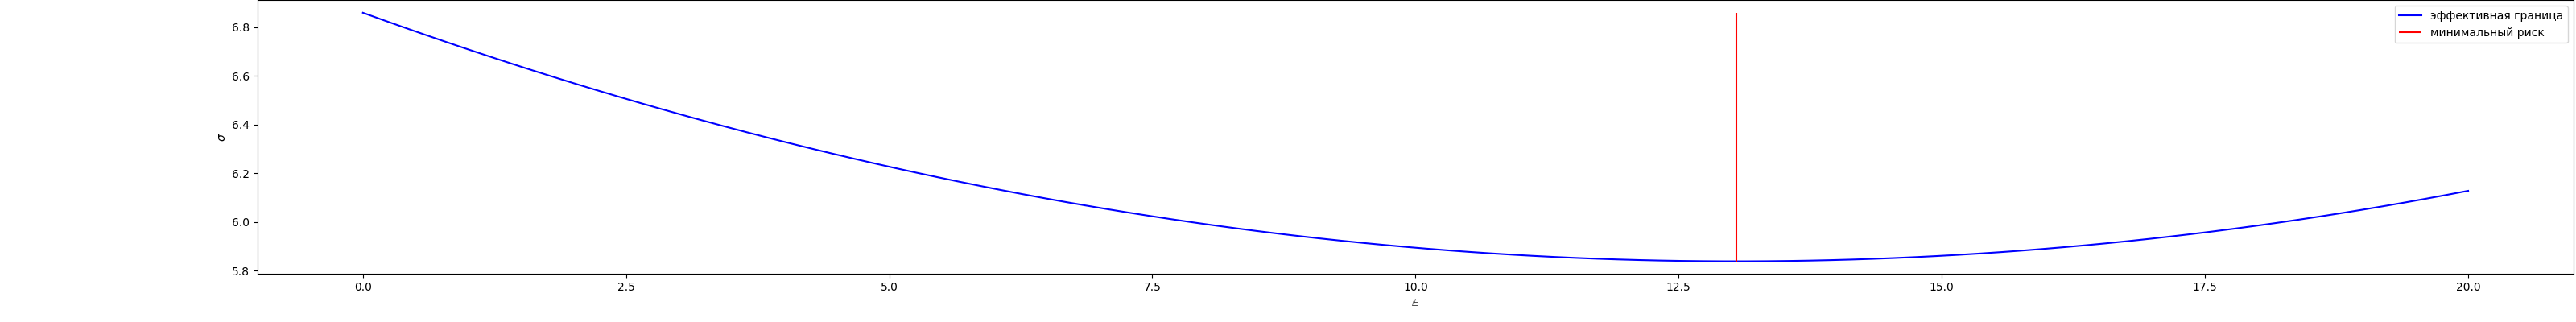

In [581]:
border = 3
ticker_cut_list = tickers_list
COV = pd.DataFrame(np.cov([data[ticker].to_numpy() for ticker in  ticker_cut_list]), columns = ticker_cut_list, index = ticker_cut_list)
display(Markdown(COV.to_markdown()))
m = df.iloc[0][ticker_cut_list].to_numpy()
cov = COV.values

solution(m, cov, True)